In [1]:
sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "NVDA", "META", "TSLA", "BRK-B", "UNH",
    "LLY", "JPM", "V", "JNJ", "XOM", "WMT", "MA", "PG", "AVGO", "CVX", "HD", "MRK",
    "ABBV", "COST", "PEP", "ADBE", "KO", "BAC", "CRM", "ORCL", "TMO", "ACN", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "LIN", "AMD", "NEE",
    "AMGN", "PM", "HON", "UNP", "UPS", "MS", "SPGI", "RTX", "INTU", "LOW", "BA",
    "IBM", "AMT", "CAT", "MDT", "PLD", "GS", "ISRG", "CVS", "NOW", "BLK", "GE",
    "DE", "T", "LRCX", "ADI", "CI", "ZTS", "SYK", "C", "TJX", "MU", "SCHW", "ADP",
    "MMC", "BDX", "MO", "PFE", "BKNG", "CHTR", "CB", "REGN", "MDLZ", "VRTX", "USB",
    "PANW", "GILD", "ELV", "LMT", "ADSK", "SO", "PGR", "TGT", "DUK", "AXP",
    "HCA", "AON", "SLB", "CL", "APD", "EOG", "TJX", "AEP", "CSX", "F", "MAR", "GM",
    "ICE", "FDX", "DG", "MNST", "NSC", "EW", "ITW", "MET", "KHC", "TRV", "PSX", "MPC",
    "COF", "SHW", "OXY", "EMR", "SRE", "ROST", "HUM", "AZO", "CDNS", "KMB", "STZ",
    "ORLY", "ADM", "RMD", "PSA", "BIIB", "IDXX", "VLO", "TT", "CMG", "PRU", "WELL",
    "PCAR", "AFL", "SPG", "CTAS", "HAL", "EXC", "DLR", "AIG", "WMB", "ED", "HPQ",
    "YUM", "CTSH", "PAYX", "AMP", "TEL", "EBAY", "WBD", "OKE", "VICI", "PPG", "FITB",
    "EFX", "D", "DFS", "ALL", "MTB", "KEYS", "ANET", "OTIS", "HES", "BKR", "TTWO",
    "APH", "WEC", "ETN", "ECL", "ROK", "MLM", "AVB", "BAX", "NEM", "XYL", "CMS",
    "DOW", "RSG", "MCK", "GWW", "CHD", "CFG", "FAST", "CAH", "NUE", "VRSK", "LEN",
    "ULTA", "CCL", "CNP", "LDOS", "VTR", "CBRE", "IFF", "TSCO", "CAG", "ZBH", "BXP",
    "HOLX", "DPZ", "LUV", "IPG", "AKAM", "MKTX", "MAS", "DRI", "SWKS", "FTNT", "RHI",
    "FANG", "PPL", "AES", "AEE", "STX", "IR", "NTRS", "WY", "HIG", "DHI",
    "CLX", "ARE", "STE", "MTD", "CDW", "CMA", "INVH", "ALGN", "FE", "KIM",
    "ATO", "SNA", "GEN", "LHX", "BALL", "TER", "NDAQ", "BEN", "CRL", "PODD", "KR",
    "HBAN", "ZBRA", "LKQ", "APA", "NTAP", "SJM", "GLW", "TSN", "BWA", "HSIC", "CPB",
    "WRB", "JKHY", "NRG", "JBHT", "TFX", "XRAY", "NWS", "NWSA", "FOX", "FOXA"
]


In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

snp500_data = None

def fetch_snp500_data(start='2005-1-01', end='2025-04-14'):
    global snp500_data
    # Explicitly set auto_adjust to False to ensure raw prices (suppress warning)
    snp500_data = yf.download('^GSPC', start=start, end=end, auto_adjust=False)
    print("S&P 500 data loaded.")

def get_close_prices():
    global snp500_data
    if snp500_data is not None:
        return snp500_data['Close']

# --------------------------
# Trading Environment
# --------------------------
import gym
import numpy as np
import yfinance as yf

class TradingEnv(gym.Env):
    def __init__(self, stock_prices, dividends, initial_cash=10000,
                 transaction_cost=0.001):
        super().__init__()
        self.stock_prices = stock_prices
        self.dividends     = dividends
        self.initial_cash  = initial_cash
        self.num_stocks    = stock_prices.shape[1]
        self.transaction_cost = transaction_cost
        
        # load S&P 500 series once
        snp = yf.download('^GSPC', start='2005-01-01', end='2024-12-31',
                          auto_adjust=False)['Close']
        self.snp500 = snp.values
        
        # action: weights for [stock₁ … stockₙ, cash], sums to 1
        self.action_space = gym.spaces.Box(
            low=0, high=1, shape=(self.num_stocks + 1,), dtype=np.float32)
        # obs: [prices₁…ₙ, holdings₁…ₙ, cash]
        obs_low  = np.zeros(self.num_stocks*2 + 1, dtype=np.float32)
        obs_high = np.full(self.num_stocks*2 + 1, np.inf, dtype=np.float32)
        self.observation_space = gym.spaces.Box(obs_low, obs_high, dtype=np.float32)
        
    def reset(self):
        self.current_step = 0
        # start 100% in cash, zero holdings
        self.cash     = float(self.initial_cash)
        self.holdings = np.zeros(self.num_stocks, dtype=np.float32)
        return self._get_obs()
    
    def _get_obs(self):
        prices = self.stock_prices[self.current_step]
        return np.concatenate([prices, self.holdings, [self.cash]])
    
    def step(self, action):
        # — normalize action to a valid weight vector
        action = np.clip(action, 1e-6, None)
        action = action / action.sum()
        
        # current prices & portfolio value
        prices      = self.stock_prices[self.current_step]
        stock_vals  = self.holdings * prices
        total_value = stock_vals.sum() + self.cash
        
        # target allocation in dollars
        target_stock_vals = action[:-1] * total_value
        target_cash_val   = action[-1]  * total_value
        
        # compute new holdings (shares) and turnover
        new_holdings = target_stock_vals / prices
        trades       = np.abs(new_holdings - self.holdings) * prices
        turnover     = trades.sum()
        
        # apply transaction cost
        cost = self.transaction_cost * turnover
        
        # move to next day
        next_prices      = self.stock_prices[self.current_step + 1]
        next_stock_value = (new_holdings * next_prices).sum()
        next_total_value = next_stock_value + target_cash_val - cost
        
        # daily returns
        snp_today = self.snp500[self.current_step]
        snp_next  = self.snp500[self.current_step + 1]
        daily_portf_ret = (next_total_value / total_value) - 1
        daily_snp_ret   = (snp_next / snp_today) - 1
        
        reward = daily_portf_ret - daily_snp_ret
        
        # commit updates
        self.holdings    = new_holdings
        self.cash        = target_cash_val - cost
        self.current_step += 1
        done = (self.current_step >= len(self.stock_prices) - 1)
        
        return self._get_obs(), reward, done, {}
    
    def render(self, mode="human"):
        prices = self.stock_prices[self.current_step - 1]
        val    = self.cash + (self.holdings * prices).sum()
        print(f"Day {self.current_step} | Portfolio Value: ${val:.2f} | Cash: ${self.cash:.2f}")

# --------------------------
# Replay Buffer
# --------------------------
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        return Transition(*zip(*transitions))
    
    def __len__(self):
        return len(self.buffer)

# --------------------------
# BCQ Networks
# --------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.net(x)

class VAE(nn.Module):
    def __init__(self, state_dim, action_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.e1 = nn.Linear(state_dim + action_dim, 256)
        self.e2 = nn.Linear(256, 256)
        self.mean = nn.Linear(256, latent_dim)
        self.log_std = nn.Linear(256, latent_dim)
        self.d1 = nn.Linear(state_dim + latent_dim, 256)
        self.d2 = nn.Linear(256, 256)
        self.d3 = nn.Linear(256, action_dim)
        self.latent_dim = latent_dim
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.e1(x))
        x = torch.relu(self.e2(x))
        mean = self.mean(x)
        log_std = self.log_std(x).clamp(-4, 15)
        std = torch.exp(log_std)
        z = mean + std * torch.randn_like(std)
        x = torch.cat([state, z], dim=1)
        x = torch.relu(self.d1(x))
        x = torch.relu(self.d2(x))
        action_recon = torch.tanh(self.d3(x))
        return action_recon, mean, std
    
    def decode(self, state, z=None):
        batch_size = state.size(0)
        if z is None:
            z = torch.randn(batch_size, self.latent_dim).to(state.device).clamp(-0.5, 0.5)
        x = torch.cat([state, z], dim=1)
        x = torch.relu(self.d1(x))
        x = torch.relu(self.d2(x))
        action = torch.tanh(self.d3(x))
        return action

class Perturbation(nn.Module):
    def __init__(self, state_dim, action_dim, phi=0.05):
        super(Perturbation, self).__init__()
        self.phi = phi
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()
        )
    
    def forward(self, state, action):
        delta = self.phi * self.net(torch.cat([state, action], dim=1))
        return delta

# --------------------------
# BCQ Agent with Epsilon Decay
# --------------------------
class BCQAgent:
    def __init__(self, state_dim, action_dim, device, discount=0.99, tau=0.005, lmbda=0.75,
                 epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        self.discount = discount
        self.tau = tau
        self.lmbda = lmbda

        # Epsilon parameters for exploration
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.q_target = QNetwork(state_dim, action_dim).to(device)
        self.q_target.load_state_dict(self.q_network.state_dict())
        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=1e-3)

        self.vae = VAE(state_dim, action_dim).to(device)
        self.vae_optimizer = optim.Adam(self.vae.parameters(), lr=1e-3)

        self.perturbation = Perturbation(state_dim, action_dim).to(device)
        self.perturbation_optimizer = optim.Adam(self.perturbation.parameters(), lr=1e-3)
        
        self.replay_buffer = ReplayBuffer(100000)
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            random_action = np.random.rand(self.action_dim)
            random_action /= random_action.sum()  # Normalize to sum to 1
            return random_action
        
        state_tensor = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        with torch.no_grad():
            num_samples = 10
            state_repeat = state_tensor.repeat(num_samples, 1)
            action_samples = self.vae.decode(state_repeat)
            # Apply perturbation and select best action based on Q-value.
            perturbed_actions = action_samples + self.perturbation(state_repeat, action_samples)
            q_values = self.q_network(state_repeat, perturbed_actions)
            best_index = q_values.argmax()
            best_action = perturbed_actions[best_index].cpu().numpy()
        # Map from [-1, 1] to [0, 1] and normalize.
        best_action = (best_action + 1) / 2
        best_action = best_action / best_action.sum()
        return best_action

    def train(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return
        
        batch = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(np.array(batch.state)).to(self.device)
        action = torch.FloatTensor(np.array(batch.action)).to(self.device)
        # Use .view(-1, 1) to ensure the rewards and done flags have shape (batch_size, 1)
        reward = torch.FloatTensor(np.array(batch.reward)).to(self.device).view(-1, 1)
        next_state = torch.FloatTensor(np.array(batch.next_state)).to(self.device)
        done = torch.FloatTensor(np.array(batch.done)).to(self.device).view(-1, 1)

        # VAE update.
        recon, mean, std = self.vae(state, action)
        recon_loss = nn.MSELoss()(recon, action)
        kl_loss = (-0.5 * torch.sum(1 + torch.log(std**2) - mean**2 - std**2, dim=1)).mean()
        vae_loss = recon_loss + 0.5 * kl_loss
        self.vae_optimizer.zero_grad()
        vae_loss.backward()
        self.vae_optimizer.step()

        # Q-network update.
        with torch.no_grad():
            num_samples = 10
            next_state_repeat = next_state.repeat(num_samples, 1)
            next_action_samples = self.vae.decode(next_state_repeat)
            next_action_samples = next_action_samples + self.perturbation(next_state_repeat, next_action_samples)
            q_values = self.q_target(next_state_repeat, next_action_samples)
            q_values = q_values.view(num_samples, batch_size, 1)
            max_q = q_values.max(0)[0]
            target_q = reward + (1 - done) * self.discount * max_q

        current_q = self.q_network(state, action)
        q_loss = nn.MSELoss()(current_q, target_q)
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # Perturbation network update.
        perturbed_actions = self.vae.decode(state)
        perturbed_actions = perturbed_actions + self.perturbation(state, perturbed_actions)
        perturb_loss = -self.q_network(state, perturbed_actions).mean()
        self.perturbation_optimizer.zero_grad()
        perturb_loss.backward()
        self.perturbation_optimizer.step()

        # Soft update target Q-network.
        for param, target_param in zip(self.q_network.parameters(), self.q_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# --------------------------
# Main Training Loop
# --------------------------
if __name__ == "__main__":
    # Set random seeds for reproducibility
    start = "2005-01-01"
    end = "2024-12-31"
    random.seed(2004)
    np.random.seed(2004)
    torch.manual_seed(2004)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(2004)
    
    # Device configuration: use GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # Stock tickers and data download.
    tickers = sp500_tickers
    dividends = {}
    for item in tickers:
        ticker_obj = yf.Ticker(item)
        # Use .ffill() instead of .fillna(method='ffill')
        dividends[item] = pd.Series(ticker_obj.dividends[start:end].values.astype(np.float32)).ffill()
    print("Downloading stock data...")
    # Explicitly set auto_adjust and update fillna calls
    data = yf.download(tickers, start=start, end=end, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    stock_prices = data.values.astype(np.float32)
    
    # Create environment.
    env = TradingEnv(stock_prices, dividends, initial_cash=10000)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    # Initialize BCQ agent with epsilon decay parameters.
    agent = BCQAgent(state_dim, action_dim, device,
                     epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995)
    
    # Training parameters.
    num_episodes = 481
    batch_size = 64
    print_interval = 5
    episode_rewards = []
    portfolio_values = []
    
    print("Starting training...")
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        total_reward = 0.0
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.train(batch_size)
            state = next_state
            total_reward += reward
            
            if env.current_step == 2005:
                print(f"Episode {episode} at 2k")
                # break
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        
        final_prices = env.stock_prices[-1]
        portfolio_value = env.cash + np.sum(env.holdings * final_prices)
        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)
        
        if episode % print_interval == 0:
            print(f"Episode {episode}")
            # Convert total_reward to a float before formatting.
            print(f"Reward: ${float(total_reward):.2f} - ")
            print(f"Portfolio Value: ${portfolio_value:.2f} - ")
            print(f"Cash: ${env.cash:.2f} - ")
            print(f"Epsilon: {agent.epsilon:.4f}")

    print("\nTraining completed!")
    print("\n===== Final Training Episode Summary =====")
    initial_portfolio_value = 10000.00
    final_portfolio_value = portfolio_values[-1]
    total_change = final_portfolio_value - initial_portfolio_value
    percentage_change = (total_change / initial_portfolio_value) * 100

    print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Change: ${total_change:.2f} ({percentage_change:.2f}%)\n")
    
    print("Stock Breakdown:")
    for i, ticker in enumerate(tickers):
        initial_stock_value = (0 / env.num_stocks)
        final_stock_value = env.holdings[i] * final_prices[i]
        change = final_stock_value - initial_stock_value
        print(f"{ticker}: Initial ${initial_stock_value:.2f}, Final ${final_stock_value:.2f}, Change ${change:.2f}")
    print(f"Cash at End: ${env.cash:.2f}")

Using device: cuda


[*********************100%***********************]  273 of 273 completed
[*********************100%***********************]  1 of 1 completed


Starting training...
Episode 1 at 2k
Episode 2 at 2k
Episode 3 at 2k
Episode 4 at 2k
Episode 5 at 2k
Episode 5
Reward: $-2.56 - 
Portfolio Value: $3887.66 - 
Cash: $-1.96 - 
Epsilon: 0.9752


/scratch/4078994.1.l40s/ipykernel_1965073/4158562044.py:377: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Reward: ${float(total_reward):.2f} - ")


Episode 6 at 2k
Episode 7 at 2k
Episode 8 at 2k
Episode 9 at 2k
Episode 10 at 2k
Episode 10
Reward: $-2.62 - 
Portfolio Value: $3632.23 - 
Cash: $22.20 - 
Epsilon: 0.9511
Episode 11 at 2k
Episode 12 at 2k
Episode 13 at 2k
Episode 14 at 2k
Episode 15 at 2k
Episode 15
Reward: $-2.88 - 
Portfolio Value: $2825.51 - 
Cash: $17.50 - 
Epsilon: 0.9276
Episode 16 at 2k
Episode 17 at 2k
Episode 18 at 2k
Episode 19 at 2k
Episode 20 at 2k
Episode 20
Reward: $-2.74 - 
Portfolio Value: $3215.46 - 
Cash: $18.07 - 
Epsilon: 0.9046
Episode 21 at 2k
Episode 22 at 2k
Episode 23 at 2k
Episode 24 at 2k
Episode 25 at 2k
Episode 25
Reward: $-2.90 - 
Portfolio Value: $2755.59 - 
Cash: $4.95 - 
Epsilon: 0.8822
Episode 26 at 2k
Episode 27 at 2k
Episode 28 at 2k
Episode 29 at 2k
Episode 30 at 2k
Episode 30
Reward: $-2.89 - 
Portfolio Value: $2773.70 - 
Cash: $8.94 - 
Epsilon: 0.8604
Episode 31 at 2k
Episode 32 at 2k
Episode 33 at 2k
Episode 34 at 2k
Episode 35 at 2k
Episode 35
Reward: $-2.95 - 
Portfolio Value: 

IndexError: index 273 is out of bounds for axis 0 with size 273

# Visualizations

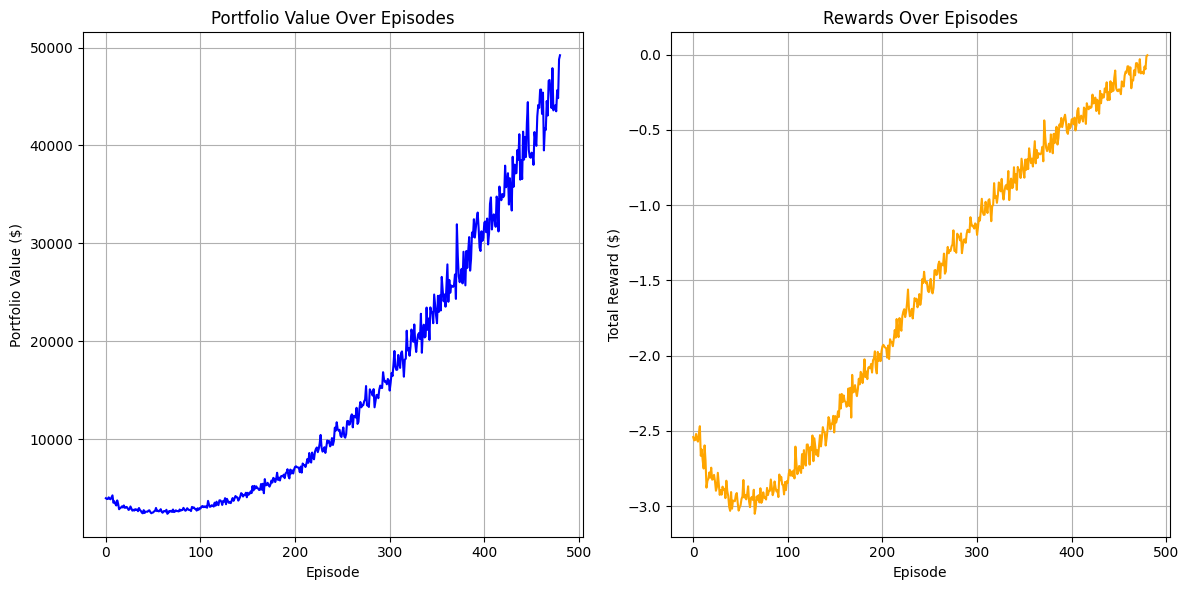


Plotting portfolio value, cash holdings, and individual stock values over the last episode...


/scratch/4078994.1.l40s/ipykernel_1965073/2785688908.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


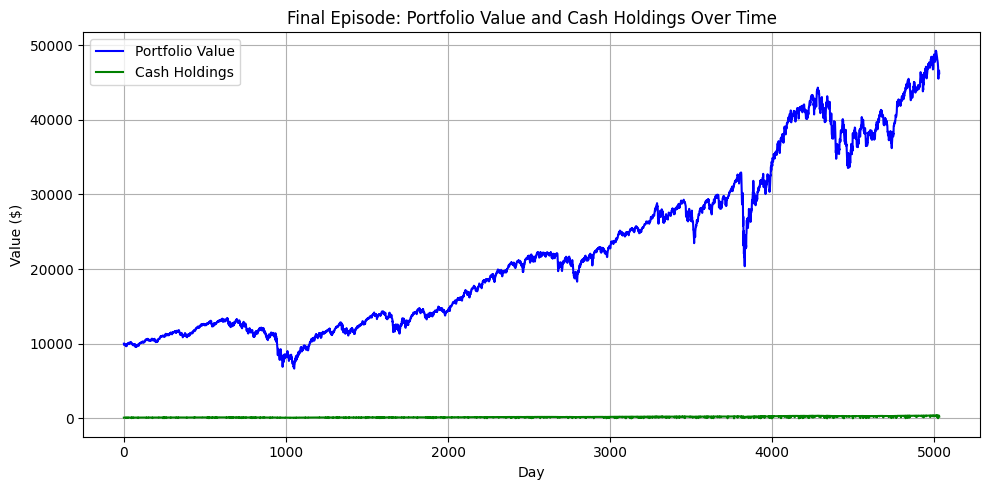

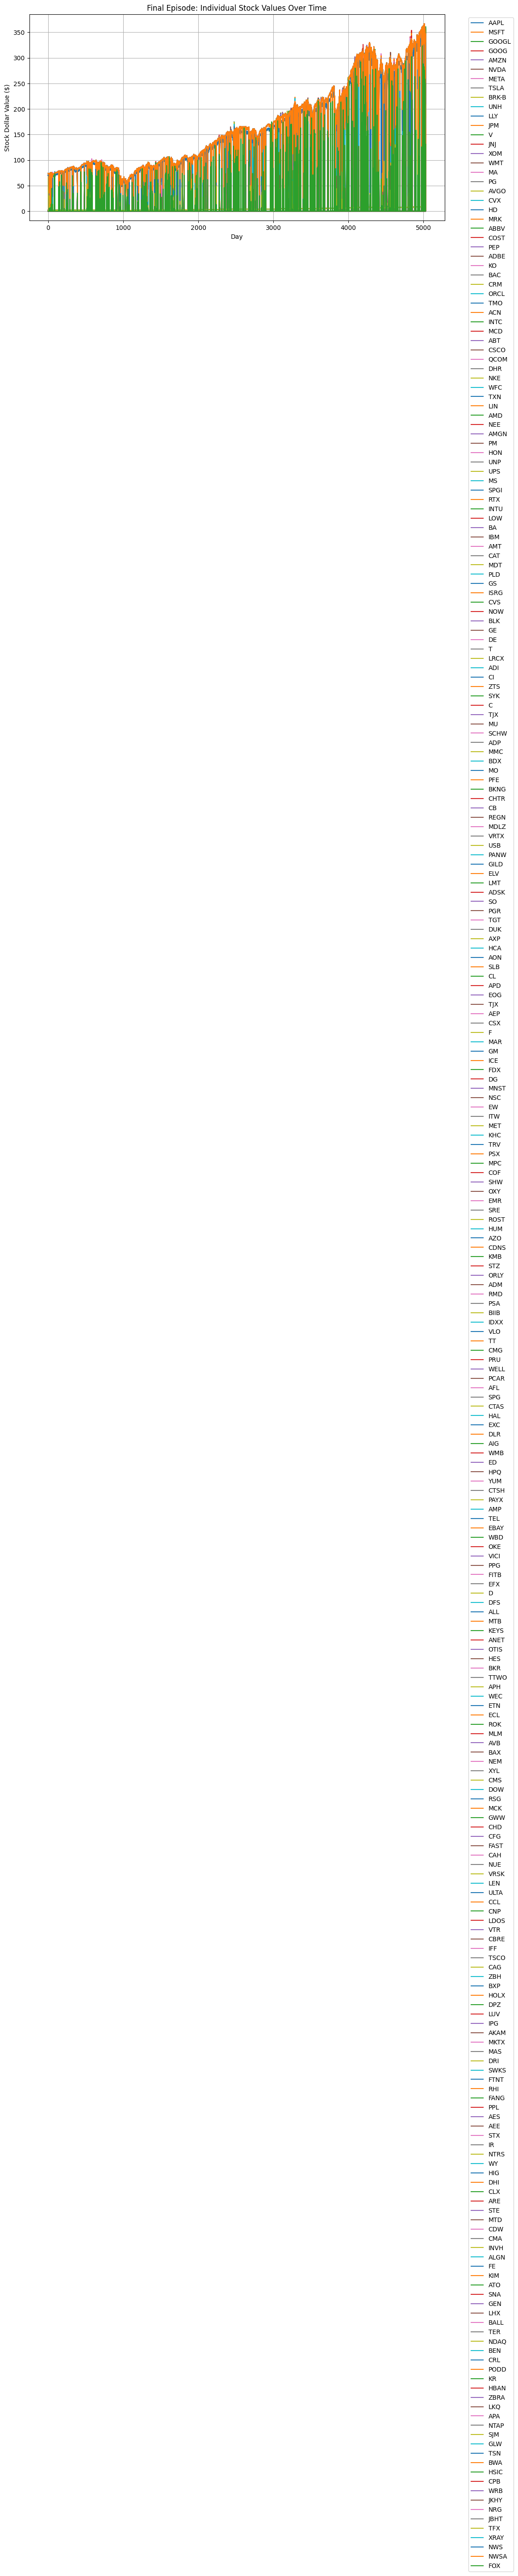

In [3]:
# Plot overall episode performance (Portfolio Value and Rewards over Episodes)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(portfolio_values, label="Portfolio Value", color="blue")
plt.xlabel("Episode")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Episodes")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(episode_rewards, label="Reward", color="orange")
plt.xlabel("Episode")
plt.ylabel("Total Reward ($)")
plt.title("Rewards Over Episodes")
plt.grid(True)
plt.tight_layout()
plt.show() 

# --------------------------
# Plot daily performance of final episode with Cash Graph and individual Stock Graphs
# --------------------------
print("\nPlotting portfolio value, cash holdings, and individual stock values over the last episode...")

daily_values = []        # total portfolio value (cash + stock values)
daily_cash = []          # cash-only values
daily_stock_values = [[] for _ in range(env.num_stocks)]  # one list per stock

state = env.reset()
done = False

while not done:
    action = agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    current_prices = env.stock_prices[env.current_step - 1]
    
    # Calculate total portfolio value for the day.
    portfolio_value = env.cash + np.sum(env.holdings * current_prices)
    daily_values.append(portfolio_value)
    
    # Record cash holdings.
    daily_cash.append(env.cash)
    
    # Record each stock's current dollar value (shares * price).
    for i in range(env.num_stocks):
        stock_value = env.holdings[i] * current_prices[i]
        daily_stock_values[i].append(stock_value)

# Plot portfolio value and cash holdings on the same graph.
plt.figure(figsize=(10, 5))
plt.plot(daily_values, label="Portfolio Value", color="blue")
plt.plot(daily_cash, label="Cash Holdings", color="green")
plt.xlabel("Day")
plt.ylabel("Value ($)")
plt.title("Final Episode: Portfolio Value and Cash Holdings Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.figure(figsize=(12, 6))
for i in range(env.num_stocks):
        plt.plot(daily_stock_values[i], label=f"{tickers[i]}")
plt.xlabel("Day")
plt.ylabel("Stock Dollar Value ($)")
plt.title("Final Episode: Individual Stock Values Over Time")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


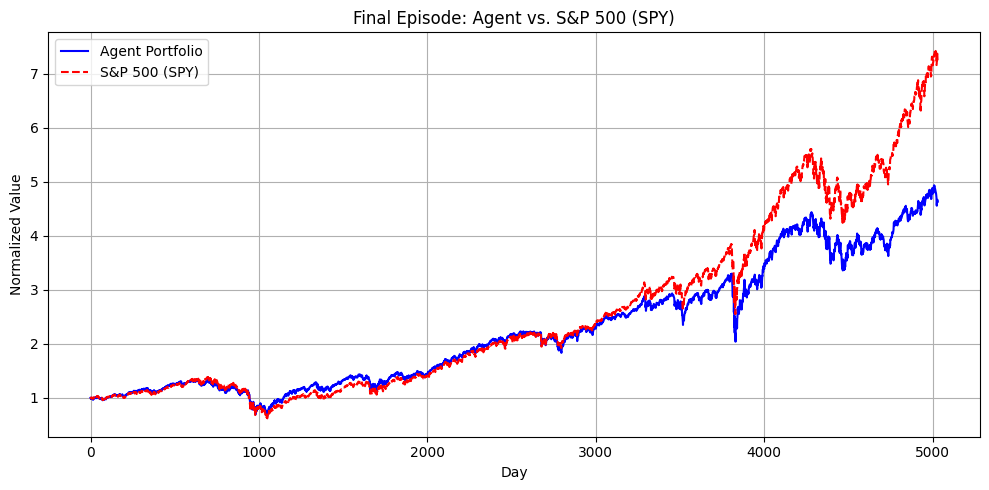

In [4]:
import yfinance as yf

# Get S&P 500 proxy (e.g., SPY ETF) data over the final episode period.
spy_data = yf.download("SPY", start=start, end=end)["Close"].ffill().bfill().values

# Get only the portion of SPY matching the length of your final episode.
# (assuming one trading day per step)
spy_final_episode = spy_data[-len(daily_values):]

# Normalize both to the same starting value for fair comparison
portfolio_base = daily_values[0]
spy_base = spy_final_episode[0]

normalized_portfolio = [v / portfolio_base for v in daily_values]
normalized_spy = [v / spy_base for v in spy_final_episode]

# Plot normalized values
plt.figure(figsize=(10, 5))
plt.plot(normalized_portfolio, label="Agent Portfolio", color="blue")
plt.plot(normalized_spy, label="S&P 500 (SPY)", color="red", linestyle="--")
plt.xlabel("Day")
plt.ylabel("Normalized Value")
plt.title("Final Episode: Agent vs. S&P 500 (SPY)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
